In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

# Stratifier for resistances

In [7]:
def find_top_resistances(csv_path, species_column = 'species'):
    df = pd.read_csv(csv_path, low_memory=False)
    df = df[~df[species_column].str.contains("MIX!")]
    antibiotic_cols = [col for col in df.columns if '_' not in col and col not in ['code', species_column]]
    resistance_counts = df[antibiotic_cols].apply(lambda x: (x == 'R').sum())
    return resistance_counts.nlargest(25).index.tolist()

def unify_and_filter(csv_paths, top_resistances, species_column = 'species'):
    for path in csv_paths:
        df = pd.read_csv(path, low_memory=False)
        base_path = os.path.split(path)[0]
        base_file = os.path.split(path)[1].split('.')[0]
        df = df[['code', species_column] + top_resistances]
        df.to_csv(f'{base_path}/{base_file}_filtered.csv', index=False)

In [17]:
DATA_PATH = "/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/"
DRIAMS_PATHS = os.listdir(DATA_PATH)
ID_PATHS = []
for root, dir, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith('clean.csv'):
            ID_PATHS.append(os.path.join(root, file))
ID_PATHS = sorted(ID_PATHS)

all_top_resistances = set()
for path in ID_PATHS:
    top_resistances = find_top_resistances(path)
    all_top_resistances.update(top_resistances)
unique_top_resistances = list(all_top_resistances)
unify_and_filter(ID_PATHS, unique_top_resistances)

In [12]:
DATA_PATH = "/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/"
DRIAMS_PATHS = os.listdir(DATA_PATH)
FILTERED_ID_PATHS = []
for root, dir, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith('filtered.csv'):
            FILTERED_ID_PATHS.append(os.path.join(root, file))
FILTERED_ID_PATHS = sorted(FILTERED_ID_PATHS)
print(FILTERED_ID_PATHS)

['/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2015_clean_filtered.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2016_clean_filtered.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2017_clean_filtered.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2018_clean_filtered.csv']


In [19]:
def encode_resistances(value):
    if value in ['R', 'I', 'R(1)']:
        return 1
    elif value == 'S' or pd.isnull(value) or value == '-':
        return 0
    else:
        raise ValueError(f'Unexpected value: {value}')

def is_unknown_pattern(value):
    if re.match(r'(R|I|S)\(\d+\)(,?\s?(R|I|S)\(\d+\))*', str(value)):
        return True
    return False

def stratified_resistance_split(csv_path: str, validation_size: int=0.10, species_column: str='species', min_observations: int = 15):
    # Setting up file structure stuff
    base_path = os.path.split(csv_path)[0]
    if not os.path.isdir(os.path.join(base_path, 'resistance')):
        os.mkdir(os.path.join(base_path, 'resistance'))
    base_path_resist = os.path.join(base_path, 'resistance')
    base_file = os.path.split(csv_path)[1].rsplit('.', 1)[0]

    df = pd.read_csv(csv_path, low_memory=False)

    # Exclude "MIX!" species
    excluded_df = df[df[species_column].str.contains("MIX!")]
    df = df[~df[species_column].str.contains("MIX!")]
    
    # Identify columns for resistance without '_' and with no 'R'/'I'
    antibiotic_cols = [col for col in df.columns[2:] if '_' not in col]
    resistance_df = df[antibiotic_cols]
    #active_resistance_cols = resistance_df.apply(lambda x: (x == 'R') | (x == 'I')).sum() >= min_observations

    # Log removal of antibiotics with no observations
    #removed_antibiotics = active_resistance_cols[~active_resistance_cols].index.tolist()
    #with open(f'{base_path_resist}/{base_file}_removed_antibiotics.txt', 'w') as f:
    #    for antibiotic in removed_antibiotics:
    #        f.write(f'{antibiotic}\n')

    # Update antibiotic_cols var after removal
    #antibiotic_cols = [col for col in antibiotic_cols if active_resistance_cols[col]]
    
    # Exlude unknown resistance patterns
    unknown_pattern_df = resistance_df.map(is_unknown_pattern)
    rows_with_unknown = unknown_pattern_df.any(axis=1)
    excluded_df = pd.concat([excluded_df, df[rows_with_unknown]])

    # Exlude rows from original df
    df = df[~rows_with_unknown]
    resistance_df = resistance_df[~rows_with_unknown]
    
    # Filter out columns with no observations
    #resistance_df = resistance_df.loc[:, active_resistance_cols]
    
    # Convert observations to binary
    binary_resistance_df = resistance_df.map(encode_resistances)
    
    # Create train/test split
    X = df[['code', 'species']].values
    y = binary_resistance_df.values

    X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=validation_size)

    # Stack data as columns
    train_val_data = np.column_stack((X_train, y_train))
    test_data = np.column_stack((X_test, y_test))

    # Convert to DataFrames
    train_val_df = pd.DataFrame(train_val_data)
    test_df = pd.DataFrame(test_data)

    # Apply column names
    train_val_df.columns = ['code', 'species'] + antibiotic_cols
    test_df.columns = ['code', 'species'] + antibiotic_cols

    # Save files
    df.to_csv(f'{base_path_resist}/{base_file}_filtered.csv', index=False)
    train_val_df.to_csv(f'{base_path_resist}/{base_file}_train_val.csv', index=False)
    test_df.to_csv(f'{base_path_resist}/{base_file}_test.csv', index=False)
    excluded_df.to_csv(f'{base_path_resist}/{base_file}_excluded.csv', index=False)


In [20]:
for path in FILTERED_ID_PATHS:
    stratified_resistance_split(path)

In [8]:
# Locate files containing id and type of AMR
DATA_PATH = "/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/"
DRIAMS_PATHS = os.listdir(DATA_PATH)
ID_PATHS = []
for root, dir, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith('clean.csv'):
            ID_PATHS.append(os.path.join(root, file))
ID_PATHS = sorted(ID_PATHS)

In [9]:
print(ID_PATHS)

['/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2015_clean.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2016_clean.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2017_clean.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2018_clean.csv']


In [7]:
for path in ID_PATHS:
    stratified_resistance_split(path)

## Example of multilabel stratification product

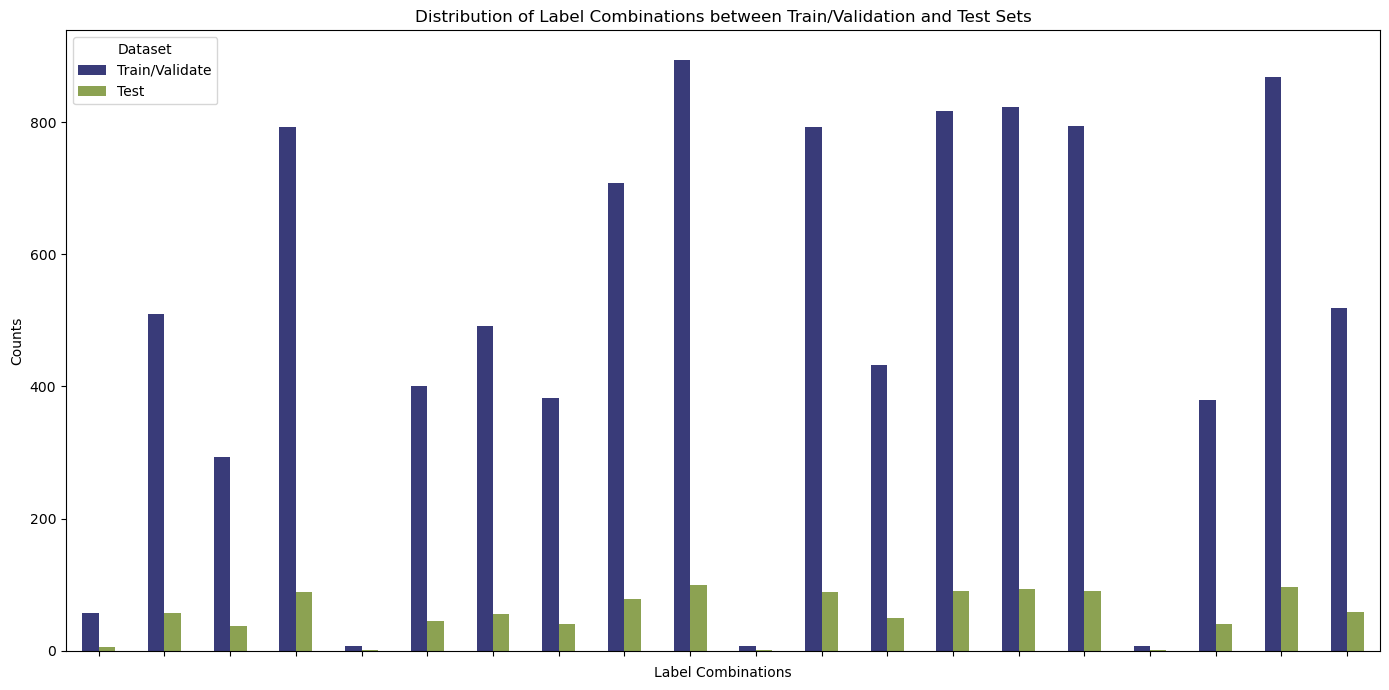

In [75]:
# Load data
train_val = pd.read_csv("/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2018_clean_train_val.csv")
test = pd.read_csv("/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2018_clean_test.csv")

# Isoalte label columns
y_train_val = train_val.iloc[:, 2:]
y_test = test.iloc[:, 2:]

# Convert to numpy arrays
y_train_val_np = y_train_val.to_numpy()
y_test_np = y_test.to_numpy()

# Apply the combinatorial matrix function
train_combinations = get_combination_wise_output_matrix(y_train_val_np, order=2)
test_combinations = get_combination_wise_output_matrix(y_test_np, order=2)

# Count frequencies
train_comb_counter = Counter(str(combination) for row in train_combinations for combination in row)
test_comb_counter = Counter(str(combination) for row in test_combinations for combination in row)

# Create df
df_comb_distribution = pd.DataFrame({
    'Train/Validate': train_comb_counter,
    'Test': test_comb_counter
}).T.fillna(0.0)

# Prep for plotting - get subset of data and pivot the frame
subset_combinations = df_comb_distribution.columns[:20]
df_plot = df_comb_distribution[subset_combinations].T

colors = [cm.tab20b(0), cm.tab20b(5)]
ax = df_plot.plot(kind='bar', figsize=(14,7), color=colors)
ax.set_title('Distribution of Label Combinations between Train/Validation and Test Sets')
ax.set_xlabel('Label Combinations')
ax.set_ylabel('Counts')
ax.set_xticklabels([])
plt.tight_layout()
plt.legend(title='Dataset')

plt.savefig("/faststorage/project/amr_driams/rasmus/Figures/data_visualisation/2018/2018_train_val_test_split.png", dpi=300)
plt.show()




## Aggregation of data

In [2]:
# Grab data

for file in os.listdir("/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/"):
    print(file)



2016_clean_filtered.csv
2015_clean_test.csv
2017_clean_excluded.csv
2017_clean_removed_antibiotics.txt
2018_clean_filtered.csv
2017_clean_train_val.csv
2015_clean_excluded.csv
2017_clean_test.csv
2016_clean_removed_antibiotics.txt
2018_clean_excluded.csv
2015_clean_train_val.csv
2016_clean_test.csv
2018_clean_test.csv
2015_clean_filtered.csv
2015_clean_removed_antibiotics.txt
2018_clean_train_val.csv
2018_clean_removed_antibiotics.txt
2016_clean_excluded.csv
2016_clean_train_val.csv
2017_clean_filtered.csv
